In [20]:
# Procesamiento de Datos para Competición Kaggle - Precios de Viviendas en Galicia
# =============================================================================

# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import os

# Configuración de visualización
#plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
pd.set_option('display.max_columns', None)

# Definir una semilla para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# =============================================================================
# 1. CARGA DE DATOS
# =============================================================================

print("Procesando datos desde cero...")
    
# Cargar los conjuntos de datos originales
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(f"Dimensiones del conjunto de entrenamiento: {train_data.shape}")
print(f"Dimensiones del conjunto de prueba: {test_data.shape}")

Procesando datos desde cero...
Dimensiones del conjunto de entrenamiento: (20000, 20)
Dimensiones del conjunto de prueba: (10000, 20)


In [21]:
# =============================================================================
# 2. FUNCIÓN AUXILIAR PARA PREPROCESAMIENTO
# =============================================================================

def preprocess_data(df, is_train=True):

    # Crear una copia para no modificar el original
    data = df.copy()
    
    # =============================================================================
    # 2.1 LIMPIEZA DE DATOS
    # =============================================================================
    
    print("Iniciando limpieza de datos...")
    
    # Eliminar duplicados en el conjunto de entrenamiento
    if is_train:
        duplicates = data.duplicated()
        if duplicates.sum() > 0:
            print(f"Eliminando {duplicates.sum()} filas duplicadas...")
            data = data.drop_duplicates().reset_index(drop=True)
        
        """
        # PEQUEÑA PRUEBA: Filtrar registros con precio de 50000 euros
        price_50k_count = (data['prezo_euros'] == 50000).sum()
        if price_50k_count > 0:
            print(f"Eliminando {price_50k_count} registros con precio exacto de 50000 euros...")
            data = data[data['prezo_euros'] != 50000].reset_index(drop=True)
            print(f"Registros restantes después del filtrado: {len(data)}")
        """

    
    # =============================================================================
    # 2.2 MANEJO DE VALORES FALTANTES
    # =============================================================================
    
    print("Manejando valores faltantes...")
    
    # Chequear valores faltantes antes del preprocesado
    missing_before = data.isnull().sum()
    print("Valores faltantes antes del preprocesado:")
    print(missing_before[missing_before > 0])
    
    # Imputar valores faltantes usando KNN para variables numéricas principales
    numeric_features = [
        'superficie_interior_m2', 
        'superficie_exterior_m2', 
        'distancia_centro_km', 
        'distancia_escola_km', 
        'indice_criminalidade'
    ]
    
    # Seleccionar columnas auxiliares para KNN (que tengan pocos o ningún NA)
    aux_features = [
        'numero_habitacions', 
        'numero_banos', 
        'ano_construccion',
        'lonxitude', 
        'latitude', 
        'temperatura_media_mes_construccion',
        'numero_arboles_xardin'
    ]
    
    # Combinar características para imputer
    imputer_features = numeric_features + aux_features
    
    # Crear una copia temporal para la imputación
    imputer_data = data[imputer_features].copy()
    
    # Inicializar KNN Imputer
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    
    # Aplicar imputación
    imputed_values = imputer.fit_transform(imputer_data)
    
    # Reemplazar valores en el DataFrame original solo para las columnas con NAs
    for i, col in enumerate(numeric_features):
        # Solo imputar si hay valores faltantes en la columna
        if data[col].isnull().sum() > 0:
            data[col] = imputed_values[:, i]
    
    # =============================================================================
    # 2.3 INGENIERÍA DE CARACTERÍSTICAS
    # =============================================================================
    
    print("Creando nuevas características...")
    
    # Año actual para cálculos de edad
    current_year = 2025
    
    # Crear características básicas
    data['edad_vivienda'] = current_year - data['ano_construccion']
    data['superficie_por_habitacion'] = data['superficie_interior_m2'] / data['numero_habitacions']
    data['superficie_total'] = data['superficie_interior_m2'] + data['superficie_exterior_m2']
    data['ratio_interior_exterior'] = data['superficie_interior_m2'] / (data['superficie_exterior_m2'] + 1)  # Evitar división por cero
    data['densidad_banos'] = data['numero_banos'] / data['superficie_interior_m2']
    data['densidad_habitaciones'] = data['numero_habitacions'] / data['superficie_interior_m2']
    
    # Características de localización
    # Calculamos la distancia euclidiana desde algunos puntos de referencia en Galicia
    # Centro aproximado de A Coruña
    data['dist_coruna'] = np.sqrt((data['lonxitude'] - (-8.4))**2 + (data['latitude'] - 43.37)**2)
    # Centro aproximado de Vigo
    data['dist_vigo'] = np.sqrt((data['lonxitude'] - (-8.72))**2 + (data['latitude'] - 42.23)**2)
    # Centro aproximado de Santiago
    data['dist_santiago'] = np.sqrt((data['lonxitude'] - (-8.54))**2 + (data['latitude'] - 42.88)**2)
    
    # Características interactivas
    data['calidad_edad'] = data['edad_vivienda'] * data.apply(
        lambda x: {'Alta': 3, 'Media': 2, 'Baixa': 1}[x['calidade_materiais']] 
        if pd.notna(x['calidade_materiais']) else 2, axis=1)
    
    data['banos_por_habitacion'] = data['numero_banos'] / data['numero_habitacions']
    
    # Características climáticas
    # Codificar la orientación según exposición solar (Sur es mejor)
    orientacion_map = {
        'Sur': 4,
        'Este': 3,
        'Oeste': 2,
        'Norte': 1
    }
    data['orientacion_valor'] = data['orientacion'].map(orientacion_map)
    
    # Codificar eficiencia energética
    eficiencia_map = {
        'A': 7,
        'B': 6,
        'C': 5,
        'D': 4,
        'E': 3,
        'F': 2,
        'G': 1
    }
    data['eficiencia_valor'] = data['eficiencia_enerxetica'].map(eficiencia_map)
    
    # Codificar calidad de materiales
    calidad_map = {
        'Alta': 3,
        'Media': 2,
        'Baixa': 1
    }
    data['calidade_valor'] = data['calidade_materiais'].map(calidad_map)
    
    # Codificar acceso a transporte público
    transporte_map = {
        'Bo': 3,
        'Regular': 2,
        'Malo': 1
    }
    data['transporte_valor'] = data['acceso_transporte_publico'].map(transporte_map)
    
    # Características de tipo de vivienda
    # One-hot encoding para tipo de edificación
    tipo_edificacion_dummies = pd.get_dummies(data['tipo_edificacion'], prefix='tipo')
    data = pd.concat([data, tipo_edificacion_dummies], axis=1)
    
    # One-hot encoding para color favorito del propietario
    color_dummies = pd.get_dummies(data['cor_favorita_propietario'], prefix='color')
    data = pd.concat([data, color_dummies], axis=1)
            
    # =============================================================================
    # 2.4 MANEJO DE OUTLIERS (Solo para entrenamiento)
    # =============================================================================
    
    if is_train:
        print("Analizando outliers...")
        
        # Detectar outliers en el precio
        Q1 = data['prezo_euros'].quantile(0.25)
        Q3 = data['prezo_euros'].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = data[(data['prezo_euros'] < lower_bound) | (data['prezo_euros'] > upper_bound)]
        
        print(f"Detectados {len(outliers)} outliers en el precio ({len(outliers)/len(data)*100:.2f}%)")
        
        # Decidimos mantener los outliers 
        #data['is_outlier'] = (data['prezo_euros'] < lower_bound) | (data['prezo_euros'] > upper_bound)
        
        # Transformar la variable objetivo para normalización (log transform)
        #data['log_prezo'] = np.log1p(data['prezo_euros'])
            
    # =============================================================================
    # 2.5 NORMALIZACIÓN Y ESCALADO
    # =============================================================================
    
    print("Escalando características numéricas...")
    
    # Lista de características numéricas para escalar
    numeric_features_to_scale = [
        'superficie_interior_m2', 
        'superficie_exterior_m2',
        'distancia_centro_km', 
        'distancia_escola_km',
        'indice_criminalidade',
        'superficie_por_habitacion',
        'superficie_total',
        'ratio_interior_exterior',
        'densidad_banos',
        'densidad_habitaciones',
        'dist_coruna',
        'dist_vigo',
        'dist_santiago',
        'calidad_edad'
    ]
    
    # No escalamos variables como número de habitaciones, baños, etc. que tienen sentido como están
    
    if is_train:
        # Inicializar el scaler
        scaler = StandardScaler()
        # Ajustar el scaler solo en los datos de entrenamiento
        scaler.fit(data[numeric_features_to_scale])
        # Guardar el scaler para uso futuro
        import joblib
        joblib.dump(scaler, 'scaler.pkl')
    else:
        # Cargar el scaler previamente ajustado
        import joblib
        try:
            scaler = joblib.load('scaler.pkl')
        except:
            print("ADVERTENCIA: No se encontró el scaler. Los datos de prueba no se escalarán correctamente.")
            return data
    
    # Aplicar la transformación
    data[numeric_features_to_scale] = scaler.transform(data[numeric_features_to_scale])
    
    # =============================================================================
    # 2.6 LIMPIAR COLUMNAS INNECESARIAS
    # =============================================================================
    
    print("Limpiando columnas innecesarias...")
    
    # Eliminar columnas originales que ya han sido procesadas o no son necesarias
    columns_to_drop = [
        # No eliminar 'id' ya que se necesita para la presentación
        'tipo_edificacion', 
        'calidade_materiais', 
        'cor_favorita_propietario', 
        'acceso_transporte_publico', 
        'orientacion', 
        'eficiencia_enerxetica'
    ]
    
    data = data.drop(columns=columns_to_drop, errors='ignore')
    
    # Verificar valores faltantes después del preprocesado
    missing_after = data.isnull().sum()
    print("Valores faltantes después del preprocesado:")
    print(missing_after[missing_after > 0])
    
    
    return data

In [22]:
# =============================================================================
# 3. APLICAR PREPROCESAMIENTO
# =============================================================================

print("\nPreprocesando conjunto de entrenamiento...")
train_processed = preprocess_data(train_data, is_train=True)

print("\nPreprocesando conjunto de prueba...")
test_processed = preprocess_data(test_data, is_train=False)

# =============================================================================
# 4. GUARDAR DATOS PROCESADOS
# =============================================================================

print("\nGuardando datos procesados...")
train_processed.to_csv('train_processed_presentacion.csv', index=False)
test_processed.to_csv('test_processed_presentacion.csv', index=False)

print("Datos procesados guardados en 'train_processed_presentacion.csv' y 'test_processed_presentacion.csv'")



Preprocesando conjunto de entrenamiento...
Iniciando limpieza de datos...
Manejando valores faltantes...
Valores faltantes antes del preprocesado:
superficie_interior_m2    1007
superficie_exterior_m2    1027
distancia_centro_km       1011
distancia_escola_km       1021
indice_criminalidade       988
dtype: int64
Creando nuevas características...
Analizando outliers...
Detectados 238 outliers en el precio (1.19%)
Escalando características numéricas...
Limpiando columnas innecesarias...
Valores faltantes después del preprocesado:
Series([], dtype: int64)

Preprocesando conjunto de prueba...
Iniciando limpieza de datos...
Manejando valores faltantes...
Valores faltantes antes del preprocesado:
superficie_interior_m2    487
superficie_exterior_m2    465
distancia_centro_km       487
distancia_escola_km       478
indice_criminalidade      512
dtype: int64
Creando nuevas características...
Escalando características numéricas...
Limpiando columnas innecesarias...
Valores faltantes después d

In [23]:
# =============================================================================
# 5. VISUALIZACIÓN DE RESULTADOS DEL PREPROCESAMIENTO
# =============================================================================

print("\nMostrando información de los datos procesados:")
print(f"Dimensiones del conjunto de entrenamiento procesado: {train_data.shape}")
print(f"Dimensiones del conjunto de prueba procesado: {test_data.shape}")

# Mostrar las primeras filas
print("\nPrimeras filas del conjunto de entrenamiento procesado:")
print(train_data.head())

# Mostrar las columnas disponibles
print("\nColumnas disponibles en el conjunto de entrenamiento procesado:")
print(train_data.columns.tolist())
"""

# Verificar nuevas características creadas
new_features = ['superficie_por_habitacion', 'edad_vivienda', 'superficie_total', 
                'ratio_interior_exterior', 'dist_coruna', 'dist_vigo', 'dist_santiago']
print("\nEstadísticas de las nuevas características:")
print(train_data[new_features].describe())

print("\nPreprocesamiento completado exitosamente.")
"""





Mostrando información de los datos procesados:
Dimensiones del conjunto de entrenamiento procesado: (20000, 20)
Dimensiones del conjunto de prueba procesado: (10000, 20)

Primeras filas del conjunto de entrenamiento procesado:
      id  superficie_interior_m2  superficie_exterior_m2  numero_habitacions  \
0  25521                   44.96                    0.00                   1   
1   4843                   93.55                   87.26                   2   
2  27734                  273.64                  187.29                   1   
3  22142                  171.82                   54.89                   4   
4  14748                     NaN                 2153.49                   1   

   numero_banos  ano_construccion  lonxitude  latitude  \
0             2              1947      -8.17     43.20   
1             2              1977      -7.23     43.60   
2             1              1996      -8.40     42.25   
3             2              1996      -6.81     43.15   
4

'\n\n# Verificar nuevas características creadas\nnew_features = [\'superficie_por_habitacion\', \'edad_vivienda\', \'superficie_total\', \n                \'ratio_interior_exterior\', \'dist_coruna\', \'dist_vigo\', \'dist_santiago\']\nprint("\nEstadísticas de las nuevas características:")\nprint(train_data[new_features].describe())\n\nprint("\nPreprocesamiento completado exitosamente.")\n'

In [24]:
display(train_processed.head())

,id,superficie_interior_m2,superficie_exterior_m2,numero_habitacions,numero_banos,ano_construccion,lonxitude,latitude,temperatura_media_mes_construccion,distancia_centro_km,distancia_escola_km,indice_criminalidade,numero_arboles_xardin,prezo_euros,edad_vivienda,superficie_por_habitacion,superficie_total,ratio_interior_exterior,densidad_banos,densidad_habitaciones,dist_coruna,dist_vigo,dist_santiago,calidad_edad,banos_por_habitacion,orientacion_valor,eficiencia_valor,calidade_valor,transporte_valor,tipo_Apartamento,tipo_Casa,tipo_Chalet adosado,color_Amarelo,color_Azul,color_Branco,color_Negro,color_Verde,color_Vermello
0,25521,-1.214878,-0.600905,1,2,1947,-8.17,43.20,24.75,-0.086440,-1.063878,0.102166,0,51938,78,-0.217224,-0.688652,0.469762,1.270152,-0.412240,-1.609578,-0.126416,-1.068397,1.049995,2.0,1,5,2,3,1,0,0,0,1,0,0,0,0
1,4843,-0.590517,-0.493874,2,2,1977,-7.23,43.60,14.06,0.324846,0.891082,0.554363,0,76891,48,-0.185006,-0.528582,-0.555120,0.027865,-0.437332,0.257816,1.474452,1.096629,0.857383,1.0,3,5,3,3,1,0,0,0,0,0,0,1,0
2,27734,1.723563,-0.371180,1,1,1996,-8.40,42.25,12.27,0.166323,1.212695,0.705095,10,261441,29,3.842041,-0.198519,-0.545937,-0.925127,-0.952642,0.108668,-1.525513,-0.732149,-0.523006,1.0,3,5,2,2,0,0,1,0,0,1,0,0,0
3,22142,0.415219,-0.533578,4,2,1996,-6.81,43.15,11.61,1.213800,-1.174828,0.102166,3,247821,29,-0.252814,-0.474498,-0.508094,-0.495763,-0.382056,1.108201,1.643372,1.648021,-0.057526,0.5,3,1,3,3,0,0,1,0,0,0,0,0,1
4,14748,1.203970,2.040511,1,1,1990,-8.76,42.92,10.04,1.954976,-0.787206,-1.204180,12,400645,35,3.124258,2.070587,-0.577338,-0.891057,-0.934219,-1.011537,-0.872973,-1.640151,-0.892180,1.0,2,1,1,3,0,1,0,0,0,0,0,1,0


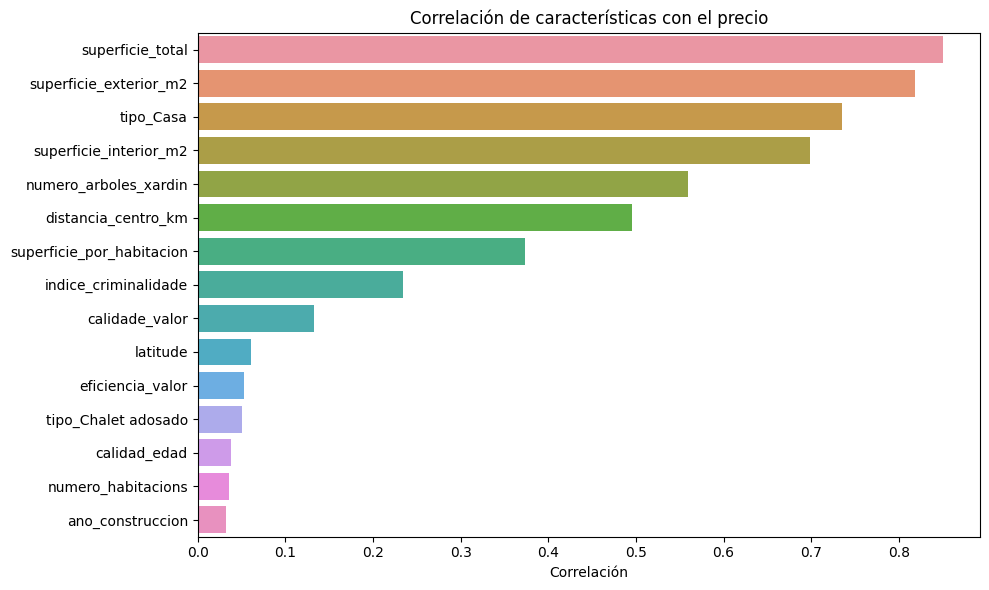

In [25]:
# =============================================================================
# 3. MATRIZ DE CORRELACIÓN CON EL PRECIO
# =============================================================================

import seaborn as sns
import matplotlib.pyplot as plt


# Calcular la correlación con la variable objetivo
correlaciones = train_processed.corr()['prezo_euros'].sort_values(ascending=False)

# Mostrar solo las correlaciones más altas (por ejemplo, top 15)
top_corr = correlaciones.drop('prezo_euros').head(15)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Correlación de características con el precio')
plt.xlabel('Correlación')
plt.tight_layout()
plt.show()


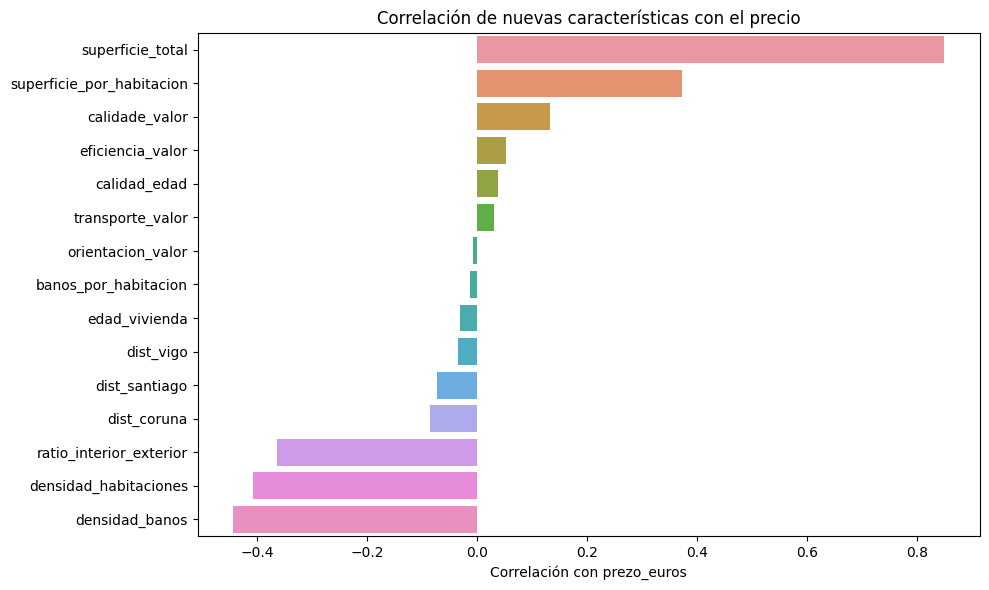

In [26]:
# =============================================================================
# CORRELACIÓN DE NUEVAS CARACTERÍSTICAS CON EL PRECIO (GRÁFICO DE BARRAS)
# =============================================================================

import seaborn as sns
import matplotlib.pyplot as plt

# Lista de nuevas características creadas
nuevas_caracteristicas = [
    'edad_vivienda',
    'superficie_por_habitacion',
    'superficie_total',
    'ratio_interior_exterior',
    'densidad_banos',
    'densidad_habitaciones',
    'dist_coruna',
    'dist_vigo',
    'dist_santiago',
    'calidad_edad',
    'banos_por_habitacion',
    'orientacion_valor',
    'eficiencia_valor',
    'calidade_valor',
    'transporte_valor'
]

# Calcular correlación con el precio
correlaciones = train_processed[nuevas_caracteristicas + ['prezo_euros']].corr()['prezo_euros']
correlaciones = correlaciones.drop('prezo_euros').sort_values(ascending=False)

# Gráfico de barras horizontales
plt.figure(figsize=(10, 6))
sns.barplot(x=correlaciones.values, y=correlaciones.index)
plt.title('Correlación de nuevas características con el precio')
plt.xlabel('Correlación con prezo_euros')
plt.tight_layout()
plt.show()
